# Set-up

In [162]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random

sns.set_theme()
colors = sns.color_palette("deep")

from math import floor, ceil, sqrt
from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene

from itertools import permutations

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [163]:
def plot_components(H, ax=None, figsize=(10, 6), labels=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    abscissa = np.linspace(0, 24, H.shape[1])
    for k in range(n_components):
        if labels:
            label = labels[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(abscissa, H[k, :], linestyle='-', label=label, **kwargs)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalized Load')
    # ax.set_title(title)
    ax.legend(loc='upper left')
    
    return fig, ax

In [164]:
region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

daytype_order = [
    'Working day',
    'Saturday',
    'Holiday'
]

# Load selected model and input data

In [166]:
method = 'WHoptindic_3comp_10000runs'
data = np.load('data/3_output/nmf_results/' + method + '.npz', allow_pickle=True)

W = data['W']
H = data['H']

In [167]:
# HOTFIX: reordering components for plotting
# reordering = np.array([2, 1, 0])
# W = W[:, reordering]
# H = H[reordering, :]

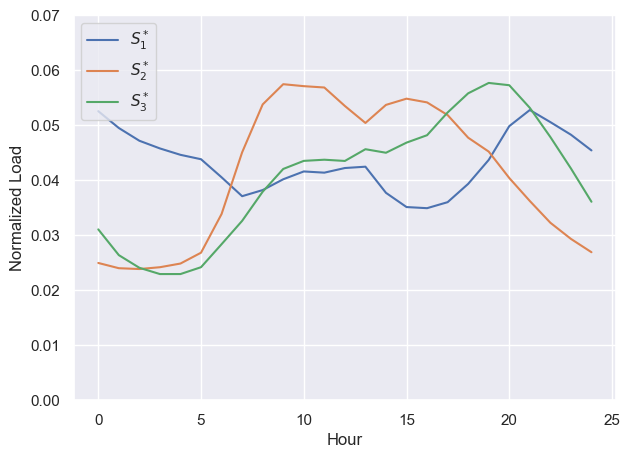

In [168]:
fig, ax = plot_components(H, labels=['$S_1^*$', '$S_2^*$', '$S_3^*$'], marker=None, linewidth=1.5, figsize=(7, 5))
left, right = ax.set_ylim((0,0.07))

In [142]:
input_df = pd.read_csv('data/2_processed/daily_curves.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11686


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-01_Holiday,620.000,553.527,505.844,458.280,416.869,403.580,418.381,430.841,447.541,535.429,...,759.323,783.827,747.433,700.825,658.620,552.943,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday


# Reconstruct the load per component

In [143]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

curves_comp = {}

for k in range(H.shape[0]):

    W_k = W[:, k]
    H_k = H[k, :]

    curves_k = (norm_X * W_k).values.reshape((len(norm_X), 1)).dot(H_k.reshape((1, H_k.shape[0])))
    # We squeeze the 25th point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
    curves_k = pd.DataFrame(curves_k[:,:-1], columns=range(H_k.shape[0]-1), index=X_unnorm.index)
    curves_k['date'] = curves_k.index.str.split('_').str[1]
    curves_k = pd.concat([curves_k, unit_info], axis=1)

    curves_comp[f'Component {k + 1}'] = curves_k

curves_comp['Component 1']

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,date,region,year,month,daytype
Calabria_2021-01-01_Holiday,72.800836,63.154002,59.878082,59.407858,62.087711,70.220419,99.004304,137.624104,168.310874,184.365170,...,189.439632,171.215519,149.519800,130.501394,113.144748,2021-01-01,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,121.936135,105.778385,100.291457,99.503865,103.992425,117.614124,165.825049,230.510420,281.908540,308.798326,...,317.297682,286.773612,250.434851,218.580396,189.509269,2021-01-02,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,149.520635,129.707665,122.979479,122.013718,127.517683,144.220895,203.338139,282.656691,345.682140,378.654957,...,389.077045,351.647792,307.088445,268.027846,232.380224,2021-01-03,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,229.309794,198.923968,188.605400,187.124275,195.565339,221.181938,311.846099,433.491656,530.149570,580.717773,...,596.701432,539.298691,470.961002,411.056375,356.386001,2021-01-04,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,156.779827,136.004942,128.950105,127.937455,133.708637,151.222786,213.210158,296.379608,362.464927,397.038567,...,407.966645,368.720211,321.997518,281.040536,243.662229,2021-01-05,Calabria,2021,01,Working day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,659.998058,572.541758,542.842917,538.579955,562.874973,636.604511,897.553550,1247.673054,1525.873276,1671.418372,...,1717.422443,1552.206223,1355.517100,1183.099966,1025.748027,2022-12-27,South,2022,12,Working day
South_2022-12-28_Working day,910.338936,789.709982,748.746209,742.866281,776.376533,878.072089,1238.000528,1720.922277,2104.645366,2305.396514,...,2368.850182,2140.966544,1869.672160,1631.856263,1414.819871,2022-12-28,South,2022,12,Working day
South_2022-12-29_Working day,422.927529,366.885429,347.854377,345.122666,360.690942,407.936916,575.153366,799.510355,977.781382,1071.046850,...,1100.526313,994.655566,868.616945,758.131844,657.300537,2022-12-29,South,2022,12,Working day
South_2022-12-30_Working day,546.590983,474.162247,449.566541,446.036081,466.156501,527.217135,743.327456,1033.286133,1263.683376,1384.219544,...,1422.318763,1285.491548,1122.599401,979.808600,849.494352,2022-12-30,South,2022,12,Working day


In [144]:
info_cols = ['region', 'year', 'month', 'daytype']

comp_df = curves_comp['Component 1'].melt(id_vars=['date']+info_cols, var_name='hour', value_name='Component 1')

for k in range(1, H.shape[0]):
    comp = f'Component {k + 1}'
    comp_df[comp] = curves_comp[comp].melt(id_vars=['date']+info_cols, var_name='hour', value_name='load')['load']

comp_df['date'] = pd.to_datetime(comp_df['date'])
comp_df['datetime'] = comp_df['date'] + pd.to_timedelta(comp_df['hour'], unit='h')
comp_df.set_index('datetime', inplace=True)
comp_df.sort_values(['region', 'date', 'hour'], inplace=True)
comp_df

,date,region,year,month,daytype,hour,Component 1,Component 2,Component 3
datetime,,,,,,,,,
2021-01-01 00:00:00,2021-01-01,Calabria,2021,01,Holiday,0,72.800836,0.000110,501.782791
2021-01-01 01:00:00,2021-01-01,Calabria,2021,01,Holiday,1,63.154002,0.000107,449.338624
2021-01-01 02:00:00,2021-01-01,Calabria,2021,01,Holiday,2,59.878082,0.000105,416.717888
2021-01-01 03:00:00,2021-01-01,Calabria,2021,01,Holiday,3,59.407858,0.000104,397.367461
2021-01-01 04:00:00,2021-01-01,Calabria,2021,01,Holiday,4,62.087711,0.000104,386.828994
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022-12-31,South,2022,12,Saturday,19,848.095174,896.621201,637.587975
2022-12-31 20:00:00,2022-12-31,South,2022,12,Saturday,20,766.508329,919.739197,701.490919
2022-12-31 21:00:00,2022-12-31,South,2022,12,Saturday,21,669.379578,933.003137,707.543524


# Up-sample

In [145]:
day_df = comp_df.groupby(['region', 'year', 'month', 'date', 'daytype'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
day_df

,region,year,month,date,daytype,Component 1,Component 2,Component 3
0,Calabria,2021,01,2021-01-01,Holiday,3432.627963,2.710537e-03,10760.415276
1,Calabria,2021,01,2021-01-02,Saturday,5749.403573,1.082142e+03,8156.782226
2,Calabria,2021,01,2021-01-03,Holiday,7050.038738,5.451515e+00,7927.706055
3,Calabria,2021,01,2021-01-04,Working day,10812.172724,1.382215e+03,5354.312060
4,Calabria,2021,01,2021-01-05,Working day,7392.316483,5.734900e+03,4075.474360
...,...,...,...,...,...,...,...,...
11681,South,2022,12,2022-12-27,Working day,31119.529951,7.214608e+02,16455.600309
11682,South,2022,12,2022-12-28,Working day,42923.338098,4.575567e-17,11527.335983
11683,South,2022,12,2022-12-29,Working day,19941.431244,1.466643e+04,14538.994026
11684,South,2022,12,2022-12-30,Working day,25772.279579,1.936684e-01,21211.732473


In [146]:
month_df = comp_df.groupby(['region', 'year', 'month'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
month_df

,region,year,month,Component 1,Component 2,Component 3
0,Calabria,2021,01,260856.823103,50469.305186,206621.544279
1,Calabria,2021,02,233342.300622,53654.827907,179400.928928
2,Calabria,2021,03,210665.392726,71239.053504,209223.294667
3,Calabria,2021,04,150868.090080,88477.361800,189634.866427
4,Calabria,2021,05,112535.084336,127081.117403,176606.057086
...,...,...,...,...,...,...
379,South,2022,08,610748.720455,763725.016613,715008.076423
380,South,2022,09,485887.869164,576912.164630,660858.311641
381,South,2022,10,480941.476623,506965.254909,631932.876450
382,South,2022,11,704140.227418,316967.491268,570750.884124


In [147]:
year_df = comp_df.groupby(['region', 'year'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
year_df

,region,year,Component 1,Component 2,Component 3
0,Calabria,2021,2.468897e+06,1.388543e+06,2.764257e+06
1,Calabria,2022,2.251594e+06,1.856216e+06,2.459400e+06
2,Centre.North,2018,1.441501e+07,1.242155e+07,7.472535e+06
3,Centre.North,2019,1.420639e+07,1.201900e+07,7.848150e+06
4,Centre.North,2020,1.234291e+07,1.144924e+07,7.380804e+06
5,Centre.North,2021,1.201011e+07,1.070994e+07,5.137399e+06
6,Centre.North,2022,1.226482e+07,1.115809e+07,4.420635e+06
7,Centre.South,2018,1.956603e+07,9.940111e+06,1.719018e+07
8,Centre.South,2019,1.997430e+07,9.761321e+06,1.794056e+07
9,Centre.South,2020,1.826115e+07,9.017656e+06,1.800341e+07


# Analysis

In [148]:
component = 'Component 1'
region = 'North'
df_plot = day_df[day_df.region == region]

fig = px.line(
    df_plot,
    x = 'date',
    y = component,
    title = f'Total Load Evolution of {component} for region {region} [MW]',
    height = 700,
    hover_data={'date': '|%B %d, %Y', component: True, 'daytype': True}
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Load')
fig.show()

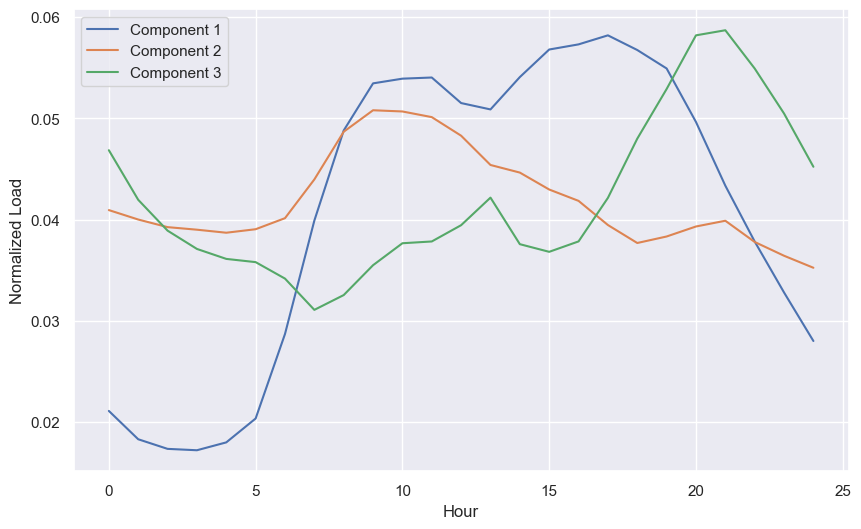

In [149]:
fig, ax = plot_components(H)

In [150]:
component = 'Component 3'
# region = 'North'

fig = px.bar(
    month_df.groupby(['year', 'month'], as_index=False)[component].sum(),
    x = 'month',
    y = component,
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [151]:
day_df.groupby(['daytype'])[[f'Component {k+1}' for k in range(H.shape[0])]].mean()

,Component 1,Component 2,Component 3
daytype,,,
Holiday,20081.649150,31666.964363,54427.917478
Saturday,22863.978895,58558.032141,39779.971856
Working day,64968.525131,52628.844835,26930.239113


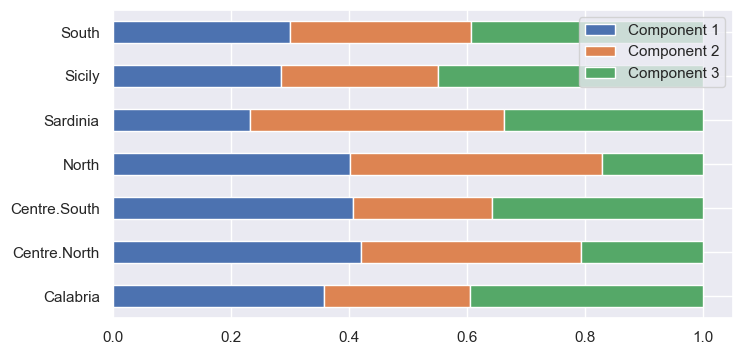

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
df_plot = year_df.groupby('region').sum().drop('year', axis=1)
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)
df_plot.plot.barh(stacked=True, ax=ax)
ax = ax.set_ylabel("")

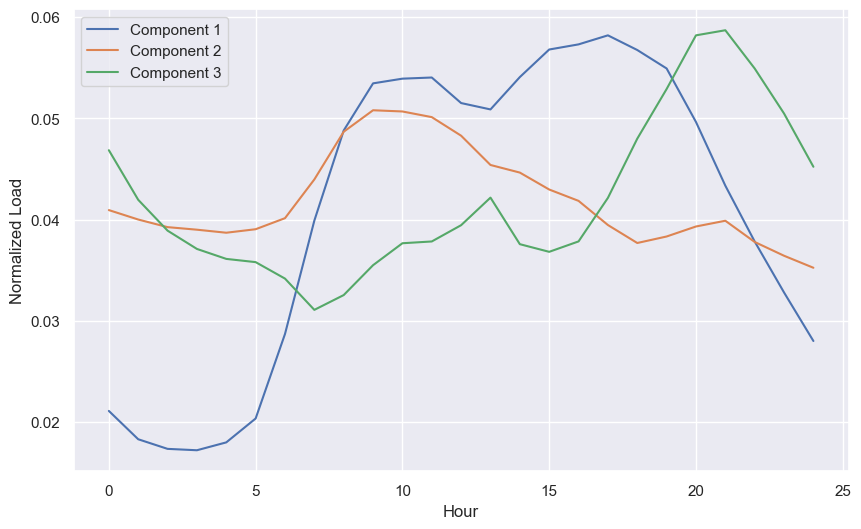

In [153]:
fig, ax = plot_components(H)

In [154]:
year_df.groupby('region').sum().drop('year', axis=1)

,Component 1,Component 2,Component 3
region,,,
Calabria,4.720491e+06,3.244759e+06,5.223656e+06
Centre.North,6.523923e+07,5.775783e+07,3.225952e+07
Centre.South,1.005560e+08,5.806868e+07,8.867344e+07
North,3.556882e+08,3.792029e+08,1.529565e+08
Sardinia,1.038520e+07,1.930567e+07,1.517436e+07
Sicily,2.706285e+07,2.506359e+07,4.269468e+07
South,3.976990e+07,4.092458e+07,5.227703e+07


In [155]:
month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)

,year,month,Component 1,Component 2,Component 3
0,2018,01,1.312575e+07,8.176268e+06,6.158994e+06
1,2018,02,1.190824e+07,8.703723e+06,5.459211e+06
2,2018,03,1.131487e+07,1.036196e+07,6.151055e+06
3,2018,04,8.096497e+06,1.003737e+07,6.376916e+06
4,2018,05,9.436621e+06,1.065754e+07,6.173158e+06
5,2018,06,9.546804e+06,1.118217e+07,6.281167e+06
6,2018,07,1.094368e+07,1.116397e+07,8.085733e+06
7,2018,08,8.196311e+06,9.027275e+06,9.123362e+06
8,2018,09,9.245006e+06,1.062563e+07,6.976972e+06
9,2018,10,1.030126e+07,1.024839e+07,6.014911e+06


Add plot of data from the IMSER

In [156]:
imser = pd.read_excel('data/1_input/indicators/IMSER.xlsx')
imser.head()

,Mese,IMSER (GWh)
0,2019-01-01,6967.533119
1,2019-02-01,6035.026729
2,2019-03-01,6228.592501
3,2019-04-01,5791.385319
4,2019-05-01,6084.349844


In [157]:
imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei.head()

,Anno,Mese,IMCEI Mensile
0,2018,2018-01-01,101.876892
1,2018,2018-02-01,104.070890
2,2018,2018-03-01,112.023582
3,2018,2018-04-01,102.915390
4,2018,2018-05-01,113.072924


In [158]:
domestic = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic.head()

,Mese,Domestico kWh,Domestico GWh
0,2020-01-01,4.741474e+09,4741.474351
1,2020-02-01,4.120931e+09,4120.931091
2,2020-03-01,4.571397e+09,4571.397146
3,2020-04-01,4.056376e+09,4056.375574
4,2020-05-01,3.817226e+09,3817.225967


Correlation between the two series: 0.318


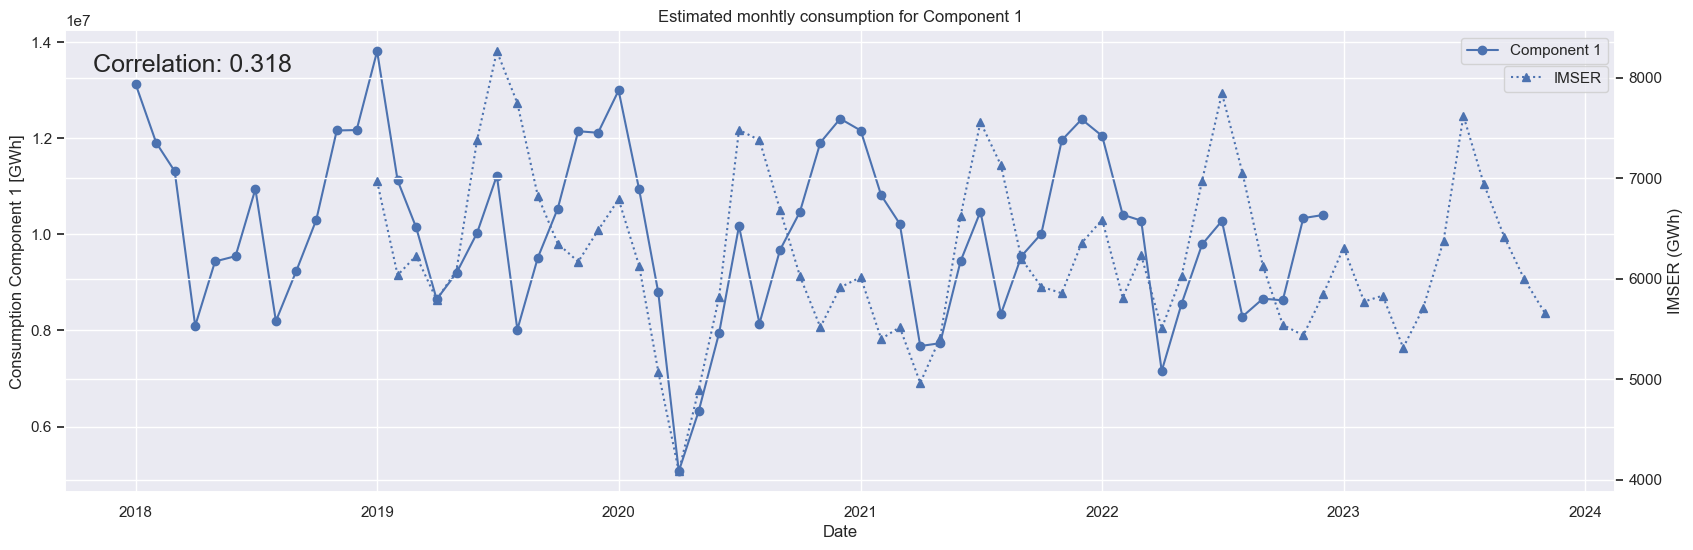

In [159]:
# Convert year and month to datetime
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot['date'] = pd.to_datetime(df_plot['year'].astype(str) + '-' + df_plot['month'], format='%Y-%m')

# Drop year and month columns
df_plot.drop(columns=['year', 'month'], inplace=True)

# Set the 'date' column as the index
df_plot.set_index('date', inplace=True)

# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
k = 0
col = f'Component {k+1}'
ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Consumption {col} [GWh]')
ax1.set_title(f'Estimated monhtly consumption for {col}')
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(imser.Mese, imser['IMSER (GWh)'], label='IMSER', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('IMSER (GWh)')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = df_plot[col].corr(imser.set_index('Mese')['IMSER (GWh)'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.85), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

print('Correlation between the two series: {:.3f}'.format(corr))

# Show plot
plt.show()

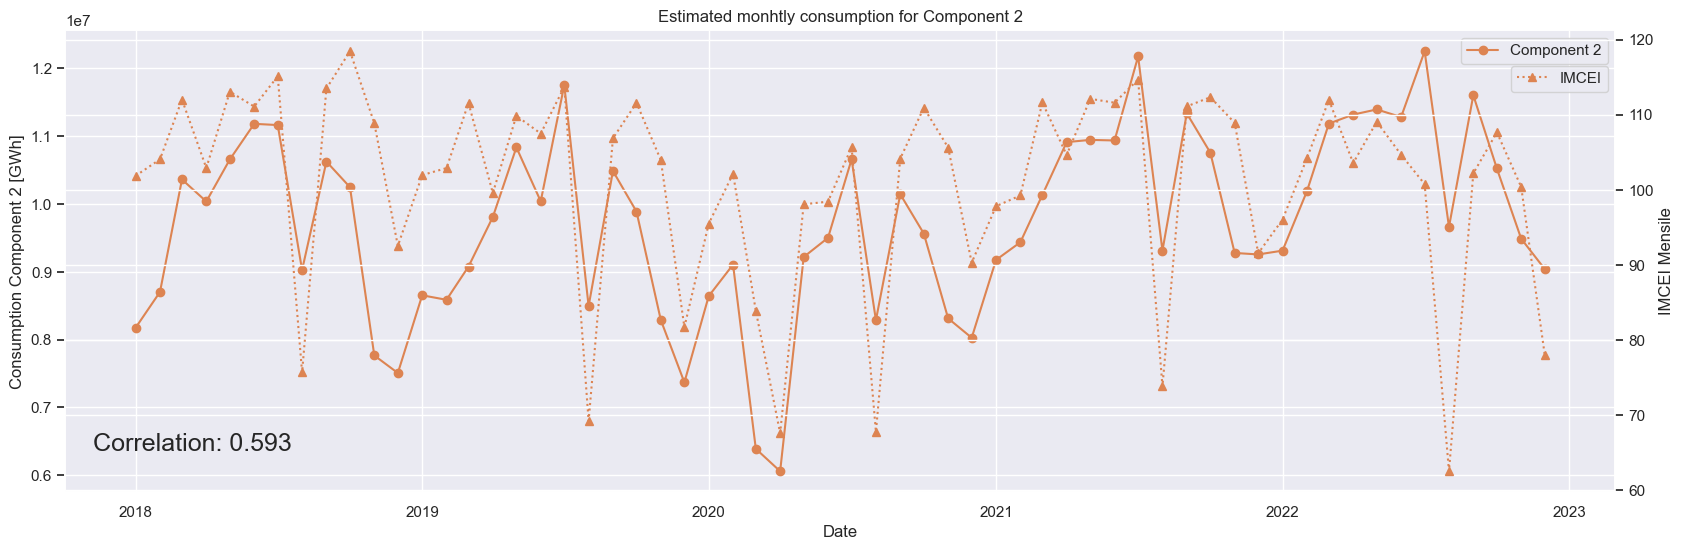

In [160]:
# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
k = 1
col = f'Component {k+1}'
ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Consumption {col} [GWh]')
ax1.set_title(f'Estimated monhtly consumption for {col}')
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(imcei.Mese, imcei['IMCEI Mensile'], label='IMCEI', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('IMCEI Mensile')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = df_plot[col].corr(imcei.set_index('Mese')['IMCEI Mensile'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.03), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

# Show plot
plt.show()

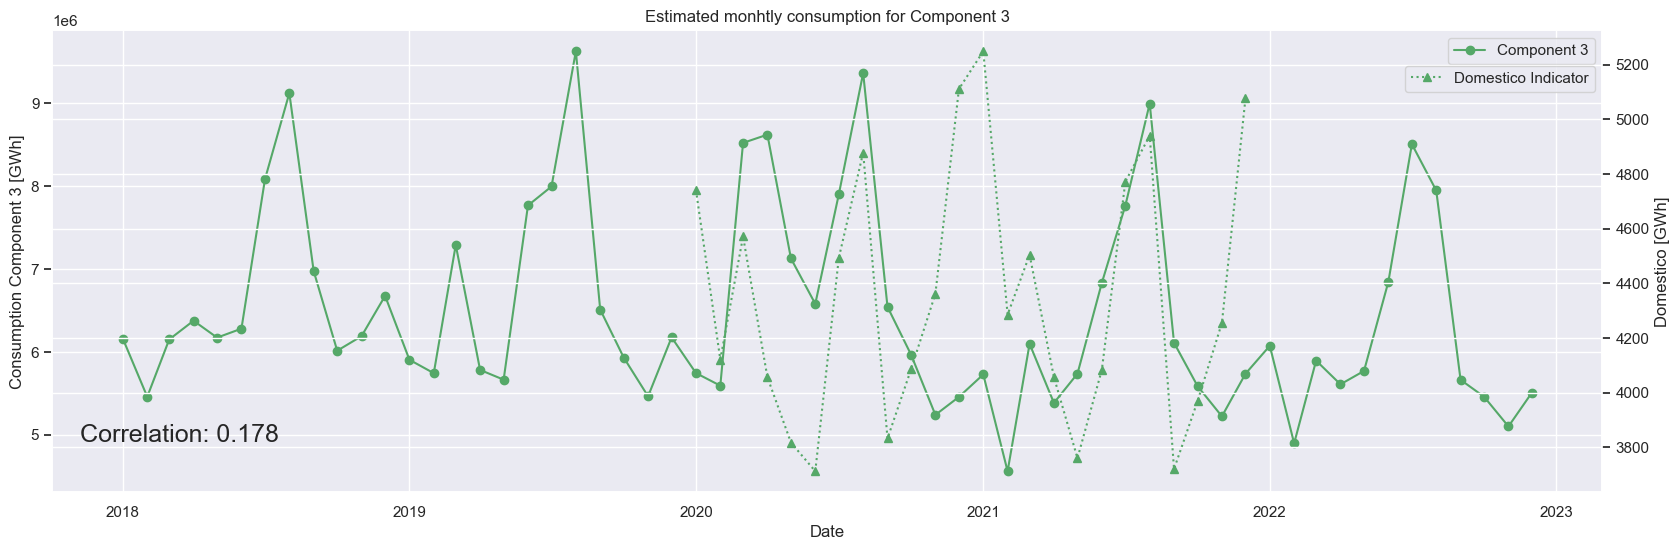

In [161]:
# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
k = 2
col = f'Component {k+1}'
ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Consumption {col} [GWh]')
ax1.set_title(f'Estimated monhtly consumption for {col}')
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(domestic.Mese, domestic['Domestico GWh'], label='Domestico Indicator', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('Domestico [GWh]')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = df_plot[col].corr(domestic.set_index('Mese')['Domestico GWh'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.05), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

# Show plot
plt.show()

In [22]:
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot.head()

,year,month,Component 1,Component 2,Component 3
0,2018,01,1.312575e+07,8.176268e+06,6.158994e+06
1,2018,02,1.190824e+07,8.703723e+06,5.459211e+06
2,2018,03,1.131487e+07,1.036196e+07,6.151055e+06
3,2018,04,8.096497e+06,1.003737e+07,6.376916e+06
4,2018,05,9.436621e+06,1.065754e+07,6.173158e+06


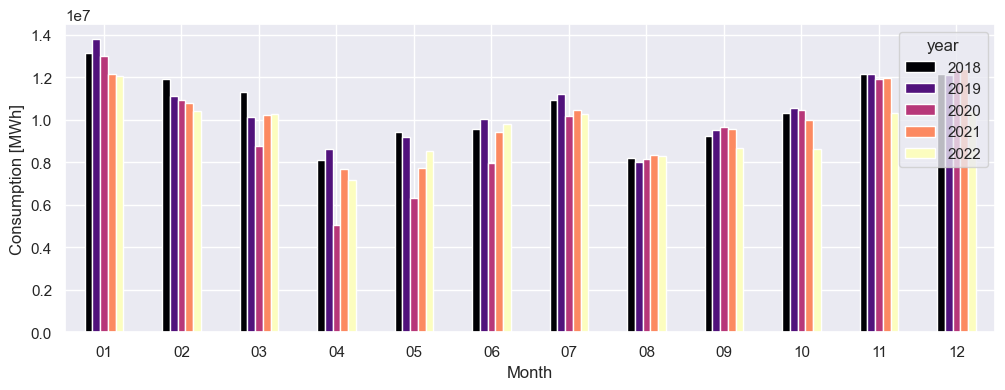

In [97]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 1').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')

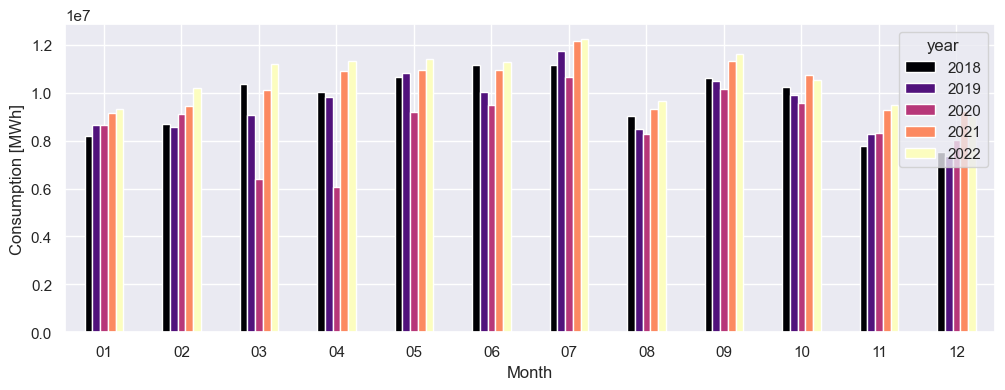

In [98]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 2').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')

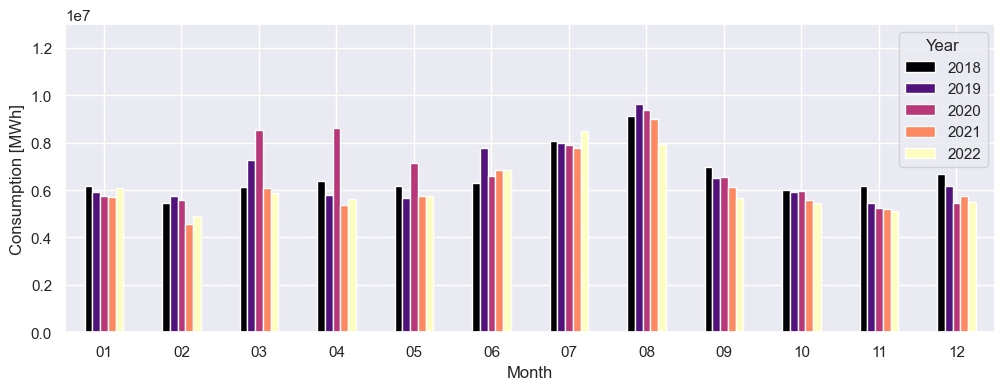

In [34]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 3').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')
ylim = plt.ylim((0., 1.3e7))
legend = plt.legend(loc='upper right', title='Year')

<HR>

# TESTS

In [41]:
df.groupby(['region', 'year'], sort=False).size()

region        year
Calabria      2021    365
              2022    365
Centre.North  2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Centre.South  2018    365
              2019    365
              2020    366
              2021    365
              2022    365
North         2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Sardinia      2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Sicily        2018    365
              2019    365
              2020    366
              2021    365
              2022    365
South         2018    365
              2019    365
              2020    366
              2021    365
              2022    365
dtype: int64